<a href="https://colab.research.google.com/github/vaishnavi-3969/AI-Hackfest/blob/main/Traffic_Sign_Classifier_and_Detector.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -q keras

In [ ]:
!pip install tensorflow

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import keras
import cv2
from keras.models import Sequential
# from keras.optimizers import Adam
from tensorflow.keras.optimizers import Adam
from keras.layers import Dense
from keras.utils.np_utils import to_categorical
from keras.layers import Dropout, Flatten
from keras.layers.convolutional import Conv2D, MaxPooling2D
import pickle
import random
import pandas as pd

In [ ]:
np.random.seed(0)

## Importing Data

In [ ]:
!git clone https://bitbucket.org/jadslim/german-traffic-signs

Cloning into 'german-traffic-signs'...
Unpacking objects: 100% (6/6), 117.80 MiB | 12.10 MiB/s, done.


In [ ]:
with open('german-traffic-signs/train.p','rb') as f:
    train_data = pickle.load(f)
with open('german-traffic-signs/valid.p','rb') as f:
    val_data = pickle.load(f)  
with open('german-traffic-signs/test.p','rb') as f:
    test_data = pickle.load(f)

In [ ]:
X_train, y_train = train_data['features'], train_data['labels']
X_val, y_val = val_data['features'], val_data['labels']
X_test, y_test = test_data['features'], test_data['labels']

In [ ]:
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

(34799, 32, 32, 3)
(4410, 32, 32, 3)
(12630, 32, 32, 3)


In [ ]:
assert(X_train.shape[0] == y_train.shape[0]), "The number of images is not equal to the number of labels"
assert(X_val.shape[0] == y_val.shape[0]), "The number of images is not equal to the number of labels"
assert(X_test.shape[0] == y_test.shape[0]), "The number of images is not equal to the number of labels"
assert(X_train.shape[1:] == (32, 32, 3)), "The dimensions of the image is not 32*32*3"
assert(X_val.shape[1:] == (32, 32, 3)), "The dimensions of the image is not 32*32*3"
assert(X_test.shape[1:] == (32, 32, 3)), "The dimensions of the image is not 32*32*3"

## Data Visualisation

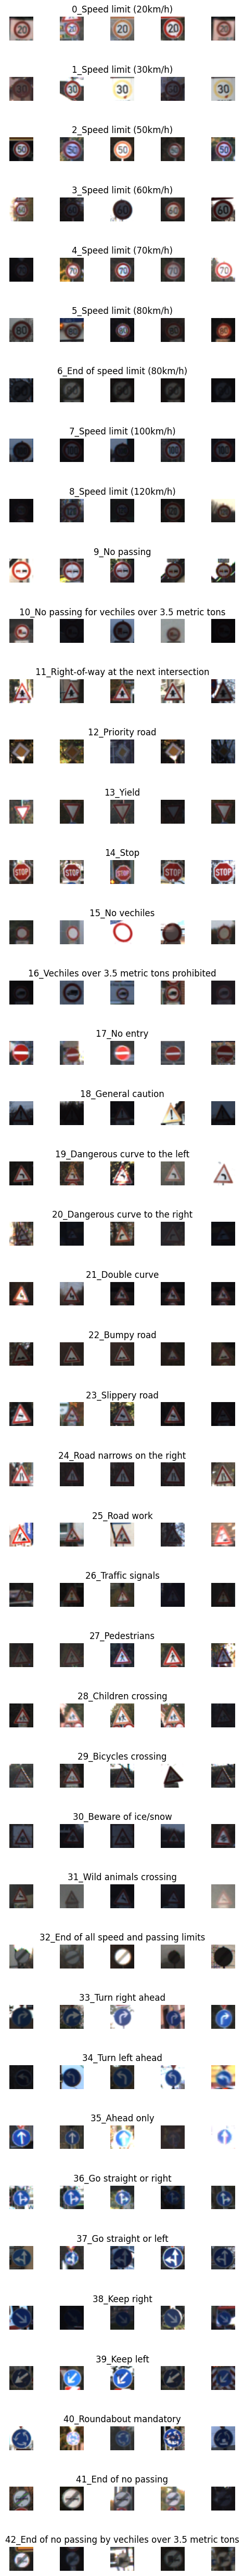

In [ ]:
data = pd.read_csv('german-traffic-signs/signnames.csv')

num_of_samples = []

cols = 5
num_classes = 43

fig, axs = plt.subplots(nrows = num_classes, ncols = cols, figsize = (5, 50))
fig.tight_layout()

for i in range(cols):
    for j, row in data.iterrows():
        x_selected = X_train[y_train == j]
        axs[j][i].imshow(x_selected[random.randint(0, (len(x_selected)-1)), :, :], cmap = plt.get_cmap("gray"))
        axs[j][i].axis("off")
        if i == 2:
            axs[j][i].set_title(str(j) + "_" + row["SignName"])
            num_of_samples.append(len(x_selected))
            
            

[180, 1980, 2010, 1260, 1770, 1650, 360, 1290, 1260, 1320, 1800, 1170, 1890, 1920, 690, 540, 360, 990, 1080, 180, 300, 270, 330, 450, 240, 1350, 540, 210, 480, 240, 390, 690, 210, 599, 360, 1080, 330, 180, 1860, 270, 300, 210, 210]


Text(0, 0.5, 'Number of images')

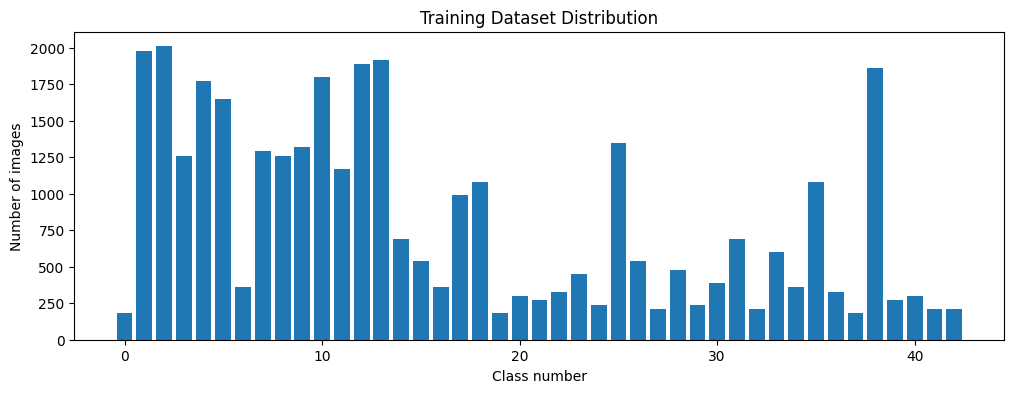

In [ ]:
print(num_of_samples)
plt.figure(figsize = (12, 4))
plt.bar(range(0, num_classes), num_of_samples)
plt.title("Training Dataset Distribution")
plt.xlabel("Class number")
plt.ylabel("Number of images")

## Data Preprocessing

(32, 32, 3)
36


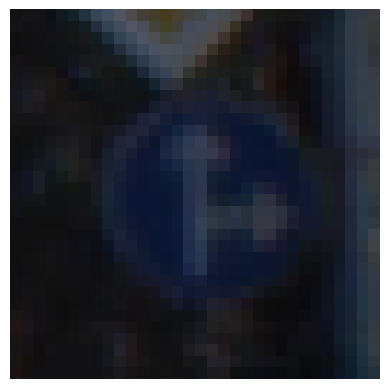

In [ ]:
plt.imshow(X_train[1000])
plt.axis('off')
print(X_train[1000].shape)
print(y_train[1000])

In [ ]:
def grayscale(img):
    image = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    plt.axis('off')
    return image

(32, 32)


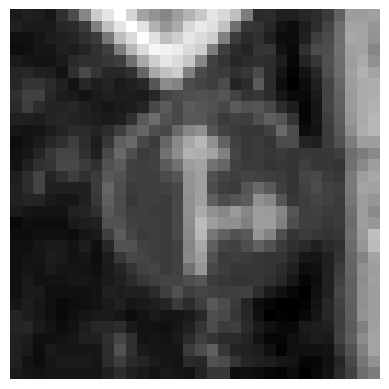

In [ ]:
img = grayscale(X_train[1000])
plt.imshow(img, cmap = 'gray')
print(img.shape)

In [ ]:
def equalize(img):
    img = cv2.equalizeHist(img)
    return img

(32, 32)


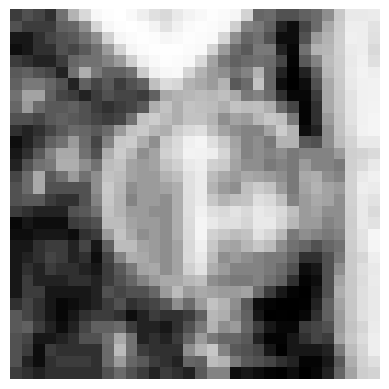

In [ ]:
img = equalize(img)
plt.imshow(img, cmap = 'gray')
plt.axis('off')
print(img.shape)

In [ ]:
def preprocessing(img):
    img = grayscale(img)
    img = equalize(img)
    img = img/255
    return img

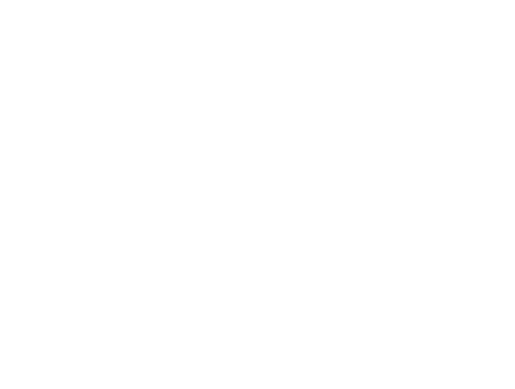

In [ ]:
X_train = np.array(list(map(preprocessing, X_train)))
X_val = np.array(list(map(preprocessing, X_val)))
X_test = np.array(list(map(preprocessing, X_test)))

### CNN
---

In [ ]:
X_train = X_train.reshape(34799, 32, 32, 1)
X_val = X_val.reshape(4410, 32, 32, 1)
X_test = X_test.reshape(12630, 32, 32, 1)

In [ ]:
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(width_shift_range = 0.1,
                  height_shift_range = 0.1,
                   zoom_range = 0.2,
                  shear_range = 0.1,
                  rotation_range = 10)

datagen.fit(X_train)

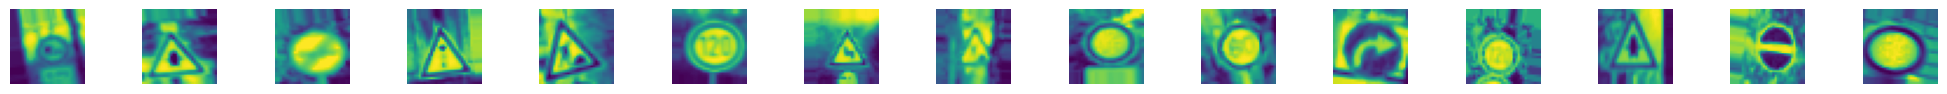

In [ ]:
batches = datagen.flow(X_train, y_train, batch_size = 20)
X_batch, y_batch = next(batches)

fig, axs = plt.subplots(1, 15, figsize = (20, 5))
fig.tight_layout()

for i in range(15):
  axs[i].imshow(X_batch[i].reshape(32, 32))
  axs[i].axis('off')

In [ ]:
y_train = to_categorical(y_train, 43)
y_val = to_categorical(y_val, 43)
y_test = to_categorical(y_test, 43)

## Neural Network

In [ ]:
def neural_model():
    model = Sequential()
    model.add(Conv2D(60, (5, 5), input_shape = (32, 32, 1), activation = 'relu'))
    model.add(Conv2D(60, (5, 5), input_shape = (32, 32, 1), activation = 'relu'))
    model.add(MaxPooling2D(pool_size = (2,2)))
    
    model.add(Conv2D(30, (3, 3), activation = 'relu'))
    model.add(Conv2D(30, (3, 3), activation = 'relu'))
    model.add(MaxPooling2D(pool_size = (2, 2)))
    
    #model.add(Dropout(0.5))
    
    model.add(Flatten())
    model.add(Dense(500, activation = 'relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation = 'softmax'))
    model.compile(Adam(lr = 0.001), loss = 'categorical_crossentropy', metrics = ['accuracy'])
    return model

In [ ]:
model = neural_model()
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 60)        1560      
                                                                 
 conv2d_1 (Conv2D)           (None, 24, 24, 60)        90060     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 12, 12, 60)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 10, 10, 30)        16230     
                                                                 
 conv2d_3 (Conv2D)           (None, 8, 8, 30)          8130      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 4, 4, 30)         0         
 2D)                                                    

In [ ]:
history = model.fit_generator(datagen.flow(X_train, y_train, batch_size = 50), steps_per_epoch =int( np.ceil(X_train.shape[0] / 50) ), epochs = 20, validation_data =(X_val, y_val), shuffle = 1)

<ipython-input-25-d8db40caec14>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(datagen.flow(X_train, y_train, batch_size = 50), steps_per_epoch =int( np.ceil(X_train.shape[0] / 50) ), epochs = 20, validation_data =(X_val, y_val), shuffle = 1)


Epoch 1/20
696/696 [==============================] - 27s 24ms/step - loss: 1.7726 - accuracy: 0.4943 - val_loss: 0.3832 - val_accuracy: 0.8785
Epoch 2/20
696/696 [==============================] - 17s 25ms/step - loss: 0.5678 - accuracy: 0.8258 - val_loss: 0.1489 - val_accuracy: 0.9583
Epoch 3/20
696/696 [==============================] - 16s 24ms/step - loss: 0.3389 - accuracy: 0.8965 - val_loss: 0.0960 - val_accuracy: 0.9685
Epoch 4/20
696/696 [==============================] - 17s 24ms/step - loss: 0.2510 - accuracy: 0.9226 - val_loss: 0.0777 - val_accuracy: 0.9760
Epoch 5/20
696/696 [==============================] - 19s 28ms/step - loss: 0.2017 - accuracy: 0.9363 - val_loss: 0.0675 - val_accuracy: 0.9791
Epoch 6/20
696/696 [==============================] - 16s 23ms/step - loss: 0.1771 - accuracy: 0.9454 - val_loss: 0.1143 - val_accuracy: 0.9667
Epoch 7/20
696/696 [==============================] - 17s 24ms/step - loss: 0.1545 - accuracy: 0.9519 - val_loss: 0.0370 - val_accuracy:

In [ ]:
model.save('signs.h5')

In [ ]:
score = model.evaluate(X_test, y_test, verbose = 1)
print('Test Score', score[0])
print('Test Accuracy', score[1])

395/395 [==============================] - 2s 4ms/step - loss: 0.1099 - accuracy: 0.9740
Test Score 0.10989006608724594
Test Accuracy 0.9739509224891663


## Testing

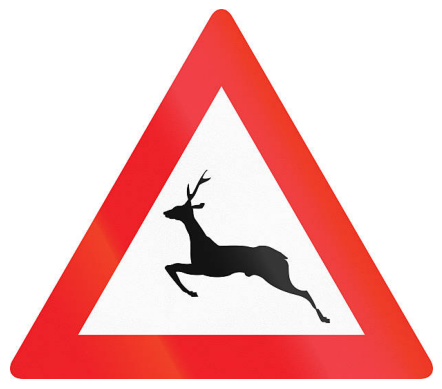

In [ ]:
import requests
from PIL import Image
url = 'https://media.istockphoto.com/id/467751164/photo/wild-animals-crossing-in-austria.jpg?s=612x612&w=0&k=20&c=WjUoo8s21L0zEpHvjuyM_uhdSW9of4HFje-TotmRrzc='
r = requests.get(url, stream=True)
image = Image.open(r.raw)
plt.axis('off')
plt.imshow(image, cmap=plt.get_cmap('gray'))

(32, 32)


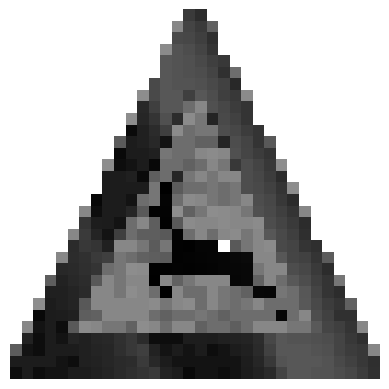

In [ ]:
img = np.asarray(image)
img = cv2.resize(img, (32, 32))
img = preprocessing(img)
plt.imshow(img, cmap = plt.get_cmap('gray'))
print(img.shape)
img = img.reshape(1, 32, 32, 1)

In [ ]:
model.predict(img)

1/1 [==============================] - 0s 224ms/step


array([[3.74515054e-07, 9.49364767e-06, 1.77240727e-05, 5.26924377e-05,
        4.67558266e-06, 5.33083448e-06, 3.58825183e-08, 1.68209354e-07,
        5.59386649e-07, 2.07815343e-03, 3.97048316e-05, 7.85343968e-09,
        1.70059824e-08, 2.98254155e-09, 1.53667685e-07, 1.47418119e-04,
        4.83122911e-08, 2.56071164e-09, 3.67604047e-02, 1.21172834e-05,
        2.21579894e-02, 5.66037197e-05, 4.83315408e-01, 9.12834518e-03,
        1.64849343e-08, 7.01208366e-04, 1.04578969e-04, 1.46853445e-08,
        6.30868655e-08, 4.82388386e-05, 9.27876442e-07, 4.45317805e-01,
        5.68253639e-11, 4.63747398e-07, 1.75671012e-05, 1.54405626e-08,
        5.11429289e-06, 1.70101035e-08, 7.06494347e-06, 3.84246022e-07,
        9.13006443e-06, 1.47967916e-09, 5.51050802e-11]], dtype=float32)

In [ ]:
#predictions = str(model.predict(img) > 0.5)



##print("predicted sign: "+ prediction )

predictions=(np.argmax(model.predict(img)))
pres = model.predict(img)
pres = np.argmax(pres).astype(int)
#prediction = predictions[1:-1]

1/1 [==============================] - 0s 20ms/step


In [ ]:
predictions

22

predicted sign: 22
predicted sign: Bumpy road


<ipython-input-33-b0ced6e3c8ff>:5: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for num, name in data.iteritems():


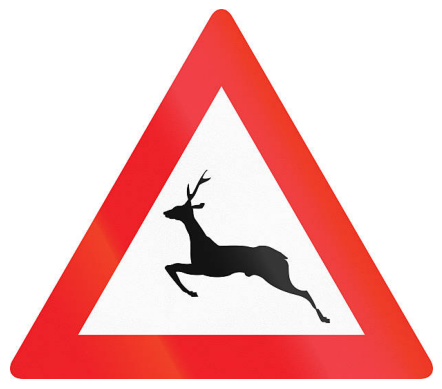

In [ ]:

pred = np.round(predictions).astype(int)
plt.imshow(image)
plt.axis('off')

for num, name in data.iteritems():
  name = name.values
  print("predicted sign: "+ str(name[pred]))


In [ ]:
!pip install -q streamlit

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.9/8.9 MB 64.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.3/184.3 kB 19.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 100.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.1/82.1 kB 10.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 164.8/164.8 kB 18.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 7.8 MB/s eta 0:00:00


In [ ]:
%%writefile app.py
import streamlit as st
import yfinance as yf

new_model = tensorflow.keras.models.load_model('/content/signs.h5')
st.title("Sign Detection")
url = st.text_input("Enter a traffic sign here ", "Start typing here")
if st.button("Get Quote"):
    r = requests.get(url, stream=True)
    image = Image.open(r.raw)
    plt.axis('off')
    plt.imshow(image, cmap=plt.get_cmap('gray'))
    img = np.asarray(image)
    img = cv2.resize(img, (32, 32))
    img = preprocessing(img)
    plt.imshow(img, cmap = plt.get_cmap('gray'))
    print(img.shape)
    img = img.reshape(1, 32, 32, 1)
    new_model.predict(img)
    predictions=(np.argmax(new_model.predict(img)))   
    pred = np.round(predictions).astype(int)
    plt.imshow(image)
    plt.axis('off')

    for num, name in data.iteritems():
      name = name.values
      print("predicted sign: "+ str(name[pred]))

Writing app.py


In [ ]:
!npm install localtunnel

npm WARN saveError ENOENT: no such file or directory, open '/content/package.json'
npm notice created a lockfile as package-lock.json. You should commit this file.
npm WARN enoent ENOENT: no such file or directory, open '/content/package.json'
npm WARN content No description
npm WARN content No repository field.
npm WARN content No README data
npm WARN content No license field.

+ localtunnel@2.0.2
added 22 packages from 22 contributors and audited 22 packages in 2.719s

3 packages are looking for funding
  run `npm fund` for details

found 0 vulnerabilities



In [ ]:
!streamlit run app.py &>/content/logs.txt &

In [ ]:
!npx localtunnel --port 8501

npx: installed 22 in 3.352s
your url is: https://cruel-zoos-jam-34-90-91-113.loca.lt


In [ ]:
%%writefile app.py
import streamlit as st
import yfinance as yf
import requests
import numpy as np
import matplotlib.pyplot as plt
import keras
import cv2
from keras.models import Sequential
# from keras.optimizers import Adam
from tensorflow.keras.optimizers import Adam
from keras.layers import Dense
from keras.utils.np_utils import to_categorical
from keras.layers import Dropout, Flatten
from keras.layers.convolutional import Conv2D, MaxPooling2D
import pickle
import random
import pandas as pd
from PIL import Image
from keras.preprocessing.image import ImageDataGenerator

def grayscale(img):
    image = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    plt.axis('off')
    return image

def equalize(img):
    img = cv2.equalizeHist(img)
    return img

def preprocessing(img):
    img = grayscale(img)
    img = equalize(img)
    img = img/255
    return img

st.title("Sign Detection")
url = st.text_input("Enter a traffic sign here ", "Start typing here")
if st.button("Get Quote"):
    r = requests.get(url, stream=True)
    image = Image.open(r.raw)
    plt.axis('off')
    plt.imshow(image, cmap=plt.get_cmap('gray'))
    img = np.asarray(image)
    img = cv2.resize(img, (32, 32))
    img = preprocessing(img)
    plt.imshow(img, cmap = plt.get_cmap('gray'))
    print(img.shape)
    img = img.reshape(1, 32, 32, 1)
    model.predict(img)
    predictions=(np.argmax(model.predict(img)))   
    pred = np.round(predictions).astype(int)
    plt.imshow(image)
    plt.axis('off')

    for num, name in data.iteritems():
      name = name.values
      print("predicted sign: "+ str(name[pred]))


Overwriting app.py


SVM
---



In [ ]:
import pickle
import numpy as np
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

In [ ]:
training_file = '/content/german-traffic-signs/train.p'
testing_file = '/content/german-traffic-signs/test.p'

In [ ]:
with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)

In [ ]:
X_train, y_train = train['features'], train['labels']
X_test, y_test = test['features'], test['labels']

In [ ]:
X_train_flat = np.array([i.flatten() for i in X_train])
X_test_flat = np.array([i.flatten() for i in X_test])

X_train_norm = X_train_flat / 255.0
X_test_norm = X_test_flat / 255.0

In [ ]:
svm = SVC(kernel='linear', C=1)
svm.fit(X_train_norm, y_train)

SVC(C=1, kernel='linear')

In [ ]:
y_pred = svm.predict(X_test_norm)

In [ ]:
accuracy = accuracy_score(y_test, y_pred)
print('Accuracy: {:.2f}%'.format(accuracy * 100))

Accuracy: 80.60%



### Decision Tree
---

In [ ]:
from sklearn.tree import DecisionTreeClassifier

In [ ]:
# Feature extraction
def extract_features(X):
    X_features = []
    for i in range(len(X)):
        feature = []
        img = X[i]
        # Extract shape features
        feature.append(img.shape[0]) # height
        feature.append(img.shape[1]) # width
        # Extract color features
        r_mean = np.mean(img[:,:,0])
        g_mean = np.mean(img[:,:,1])
        b_mean = np.mean(img[:,:,2])
        feature.append(r_mean)
        feature.append(g_mean)
        feature.append(b_mean)
        X_features.append(feature)
    return X_features

X_train_features = extract_features(X_train)
X_test_features = extract_features(X_test)

In [ ]:
# Training model
model = DecisionTreeClassifier()
model.fit(X_train_features, y_train)

DecisionTreeClassifier()

In [ ]:
score = model.score(X_test_features, y_test)
print("Accuracy:", score)

Accuracy: 0.08780680918448139


Conclusion: CNN is giving the highest accuracy of 97.3%